In [48]:
import numpy as np
from scipy.io import loadmat
import json
import os
import cv2
import matplotlib.pyplot as plt
import random
import h5py
import tensorflow as tf

## Preparing the data
The images are .jpg files inside the images folder, while the joints/annotations for the images are located in a MATLAB file (.mat). We need to use the loadmat function to load the MATLAB file into the notebook. 



In [2]:
mpii_folder = "mpii"
dataset_folder = os.path.join(mpii_folder,"mpii_human_pose_v1")
image_folder = os.path.join(dataset_folder,"images")

In [19]:
mat = loadmat(os.path.join(dataset_folder,'mpii_human_pose_v1_u12_1.mat'))
mat = mat['RELEASE']

In [21]:
j = 0
for anno in mat['annolist'][0,0][0]:
    j = j + 1
    for annorect in anno['annorect']:
        if annorect.size < 1 or 'scale' not in str(annorect.dtype):
            continue
            
        for i, annorect in enumerate(annorect):
            if annorect['scale'][0].size < 1:
                continue
            
            if 'annopoints' in str(anno['annorect'].dtype):
                print(j, annorect['annopoints'])
            

In [22]:
for i, (anno, train) in enumerate(
    zip(mat['annolist'][0,0][0], 
        mat['img_train'][0,0][0])
):
    img_name = anno['image']['name'][0,0][0]
    train = int(train)
    
    for annorect in anno['annorect']:
        if annorect.size < 1 or 'scale' not in str(annorect.dtype):
            continue
            
        for i, annorect in enumerate(annorect):
            if annorect['scale'][0].size < 1:
                continue
                
            scale = float(annorect['scale'][0, 0])
            x, y = annorect['objpos'][0, 0]
            x = int(x[0,0])
            y = int(y[0,0])
            
            if 'annopoints' in str(anno['annorect'].dtype):
                annopoints = annorect['annopoints']
                if annopoints['point'][0][0].size == 16:
                    points = annopoints[0,0]
                    joint_coords = {}
                    visible_joints = {}
                    
                    for coord in points[0][0]:
                        joint_coords[int(coord['id'][0,0])] = [float(coord['x'][0,0]), float(coord['y'][0,0])]
                        visible_joints[int(coord['id'][0,0])] = coord['is_visible'].item() if (coord['is_visible'].size > 0) else 0
                    
                    data.append({
                        'filename': img_name,
                        'joint_coords': joint_coords,
                        'visible_joints': visible_joints,
                        'for_training': train,
                        'approx_loc': {
                            'scale': scale,
                            'x': x,
                            'y': y,
                        }
                    })

In [23]:
output_json = os.path.join(mpii_folder,'data.json')
file = open(output_json, 'w')
json.dump(data, file, indent=2)

## Checkout the data
Let's show a random image and overlay the joints

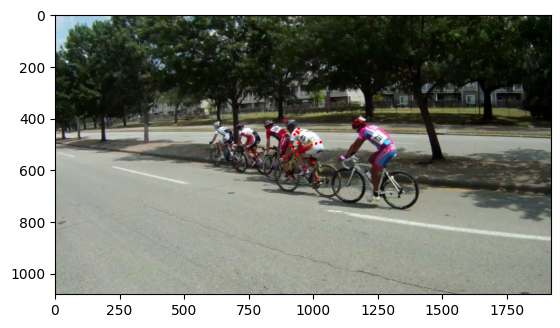

In [45]:
file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

def plot_joints(image_path, coordinates):
    image = cv2.imread(image_path)
    for joint in coordinates:
        cv2.circle(image, (int(joint[0]), int(joint[1])), 5, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# random.randrange(0,data.size)
example = data[271]
img_filename = example.get('filename')
joints = example.get('joint_coords')

joint_coords = []
for joint, coords in joints.items():
    joint_coords.append((coords[0], coords[1]))

plot_joints(os.path.join(image_folder,img_filename), joint_coords)

## Preprocessing the data
We will have to resize and crop the images to the same size, we will also save this into a HDF5 file as it handles large amounts of data very well

In [5]:
file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

In [20]:
def preprocess_image(img_path, objpos, scale, img_size=(128,128)):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    
    crop_size = int(scale * 200) # Scale factor of 200px from Dataset
    x1, y1 = int(objpos[0] - crop_size // 2), int(objpos[1] - crop_size // 2)
    x2, y2 = x1 + crop_size, y1 + crop_size
    
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    cropped_img = img[y1:y2, x1:x2]
    resized_img = cv2.resize(cropped_img, img_size)
    
    scale_factor = img_size[0] / crop_size
    transform_params = (x1, y1, scale_factor)
    
    return resized_img, transform_params

def adjust_keypoints(keypoints, transform_params):
    x1, y1, scale_factor = transform_params
    adjusted_keypoints = np.zeros((16,2), dtype=np.float32)
    
    for key, (x, y) in keypoints.items():
        x_new = (x - x1) * scale_factor
        y_new = (y - y1) * scale_factor
        adjusted_keypoints[int(key)] = [x_new, y_new]
    
    return adjusted_keypoints

In [28]:
num_samples = sum(1 for ann in data if ann['for_training'] == 1)
img_size = (128,128,3)

with h5py.File(os.path.join(mpii_folder,'dataset.h5'), 'w') as f:
    img_dataset = f.create_dataset("images", (num_samples, *img_size), dtype='uint8')
    keypoints_dataset = f.create_dataset("keypoints", (num_samples, 16, 2), dtype='float32')
    
    index = 0
    for ann in data:
        if ann['for_training'] == 1:
            img_path = os.path.join(image_folder, ann['filename'])
            objpos = (ann['approx_loc']['x'], ann['approx_loc']['y'])
            scale = ann['approx_loc']['scale']
            
            preprocessed_img, transform_params = preprocess_image(img_path, objpos, scale)
            adjusted_keypoints = adjust_keypoints(ann['joint_coords'], transform_params)
            
            img_dataset[index] = preprocessed_img 
            keypoints_dataset[index] = adjusted_keypoints
            index += 1

print("dataset.h5 successfully created")

dataset.h5 successfully created


## Load and Parse Data

In [ ]:
with h5py.File(os.path.join(mpii_folder, 'dataset.h5'), 'r') as f:
    images = np.array(f['images'])
    keypoints = np.array(f['keypoints'])

images = images.astype(np.float32) / 255

In [49]:
num_samples = sum(1 for ann in data if ann['for_training'] == 1)
dataset = tf.data.Dataset.from_tensor_slices((images, keypoints)).shuffle(num_samples, seed=42)